In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:wisig",
    "labels": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "domains_source": [1, 2, 3, 4],
    "domains_target": [1, 2, 3, 4],
    "pickle_name_target": "wisig.node3-19.stratified_ds.2022A.pkl",
    "pickle_name_source": "wisig.node3-19.stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 130}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1479], examples_per_second: 678.1589, train_label_loss: 4.8518, 


epoch: 1, [batch: 148 / 1479], examples_per_second: 10519.0934, train_label_loss: 2.9463, 


epoch: 1, [batch: 296 / 1479], examples_per_second: 10580.0232, train_label_loss: 1.9892, 


epoch: 1, [batch: 444 / 1479], examples_per_second: 10605.3954, train_label_loss: 1.4849, 


epoch: 1, [batch: 592 / 1479], examples_per_second: 10598.7168, train_label_loss: 1.0947, 


epoch: 1, [batch: 740 / 1479], examples_per_second: 10676.7110, train_label_loss: 0.9782, 


epoch: 1, [batch: 887 / 1479], examples_per_second: 10591.0712, train_label_loss: 0.7991, 


epoch: 1, [batch: 1035 / 1479], examples_per_second: 10666.8684, train_label_loss: 0.5437, 


epoch: 1, [batch: 1183 / 1479], examples_per_second: 10638.7966, train_label_loss: 0.5376, 


epoch: 1, [batch: 1331 / 1479], examples_per_second: 10614.5378, train_label_loss: 0.4419, 


epoch: 1, source_val_acc_label: 0.8766, source_val_label_loss: 0.5379, target_val_acc_label: 0.8766, target_val_label_loss: 0.5374, 


New best
epoch: 2, [batch: 1 / 1479], examples_per_second: 48.0253, train_label_loss: 0.5598, 


epoch: 2, [batch: 148 / 1479], examples_per_second: 10602.4213, train_label_loss: 0.3750, 


epoch: 2, [batch: 296 / 1479], examples_per_second: 10714.4343, train_label_loss: 0.7277, 


epoch: 2, [batch: 444 / 1479], examples_per_second: 10627.1899, train_label_loss: 0.2834, 


epoch: 2, [batch: 592 / 1479], examples_per_second: 10643.3925, train_label_loss: 0.2887, 


epoch: 2, [batch: 740 / 1479], examples_per_second: 10545.6737, train_label_loss: 0.2429, 


epoch: 2, [batch: 887 / 1479], examples_per_second: 10791.8695, train_label_loss: 0.2911, 


epoch: 2, [batch: 1035 / 1479], examples_per_second: 10653.5289, train_label_loss: 0.3000, 


epoch: 2, [batch: 1183 / 1479], examples_per_second: 10684.4637, train_label_loss: 0.2537, 


epoch: 2, [batch: 1331 / 1479], examples_per_second: 10699.8761, train_label_loss: 0.3163, 


epoch: 2, source_val_acc_label: 0.6778, source_val_label_loss: 1.5732, target_val_acc_label: 0.6778, target_val_label_loss: 1.5724, 


epoch: 3, [batch: 1 / 1479], examples_per_second: 53.3643, train_label_loss: 1.2427, 


epoch: 3, [batch: 148 / 1479], examples_per_second: 10647.4322, train_label_loss: 0.3673, 


epoch: 3, [batch: 296 / 1479], examples_per_second: 10455.1297, train_label_loss: 0.2610, 


epoch: 3, [batch: 444 / 1479], examples_per_second: 10543.6754, train_label_loss: 0.2428, 


epoch: 3, [batch: 592 / 1479], examples_per_second: 10636.9451, train_label_loss: 0.2422, 


epoch: 3, [batch: 740 / 1479], examples_per_second: 10523.9861, train_label_loss: 0.3015, 


epoch: 3, [batch: 887 / 1479], examples_per_second: 10658.8358, train_label_loss: 0.3965, 


epoch: 3, [batch: 1035 / 1479], examples_per_second: 10660.0407, train_label_loss: 0.1675, 


epoch: 3, [batch: 1183 / 1479], examples_per_second: 10652.9261, train_label_loss: 0.2650, 


epoch: 3, [batch: 1331 / 1479], examples_per_second: 10575.0610, train_label_loss: 0.2507, 


epoch: 3, source_val_acc_label: 0.8839, source_val_label_loss: 0.5664, target_val_acc_label: 0.8839, target_val_label_loss: 0.5665, 


New best
epoch: 4, [batch: 1 / 1479], examples_per_second: 53.4820, train_label_loss: 0.2816, 


epoch: 4, [batch: 148 / 1479], examples_per_second: 10568.4468, train_label_loss: 0.1350, 


epoch: 4, [batch: 296 / 1479], examples_per_second: 10570.1780, train_label_loss: 0.1683, 


epoch: 4, [batch: 444 / 1479], examples_per_second: 10646.0464, train_label_loss: 0.1094, 


epoch: 4, [batch: 592 / 1479], examples_per_second: 10623.1846, train_label_loss: 0.1482, 


epoch: 4, [batch: 740 / 1479], examples_per_second: 10608.2046, train_label_loss: 0.1047, 


epoch: 4, [batch: 887 / 1479], examples_per_second: 10536.2701, train_label_loss: 0.2416, 


epoch: 4, [batch: 1035 / 1479], examples_per_second: 10428.6814, train_label_loss: 0.1001, 


epoch: 4, [batch: 1183 / 1479], examples_per_second: 10640.6231, train_label_loss: 0.0725, 


epoch: 4, [batch: 1331 / 1479], examples_per_second: 10632.6763, train_label_loss: 0.2080, 


epoch: 4, source_val_acc_label: 0.9256, source_val_label_loss: 0.3487, target_val_acc_label: 0.9256, target_val_label_loss: 0.3482, 


New best
epoch: 5, [batch: 1 / 1479], examples_per_second: 60.9240, train_label_loss: 0.2384, 


epoch: 5, [batch: 148 / 1479], examples_per_second: 12886.5282, train_label_loss: 0.3156, 


epoch: 5, [batch: 296 / 1479], examples_per_second: 12728.0979, train_label_loss: 0.2514, 


epoch: 5, [batch: 444 / 1479], examples_per_second: 12988.1422, train_label_loss: 0.1293, 


epoch: 5, [batch: 592 / 1479], examples_per_second: 12926.7461, train_label_loss: 0.1962, 


epoch: 5, [batch: 740 / 1479], examples_per_second: 12944.4632, train_label_loss: 0.0919, 


epoch: 5, [batch: 887 / 1479], examples_per_second: 13034.6869, train_label_loss: 0.1579, 


epoch: 5, [batch: 1035 / 1479], examples_per_second: 13011.9492, train_label_loss: 0.1695, 


epoch: 5, [batch: 1183 / 1479], examples_per_second: 12901.5505, train_label_loss: 0.1529, 


epoch: 5, [batch: 1331 / 1479], examples_per_second: 12871.0943, train_label_loss: 0.2116, 


epoch: 5, source_val_acc_label: 0.9476, source_val_label_loss: 0.2358, target_val_acc_label: 0.9476, target_val_label_loss: 0.2357, 


New best
epoch: 6, [batch: 1 / 1479], examples_per_second: 69.4469, train_label_loss: 0.1918, 


epoch: 6, [batch: 148 / 1479], examples_per_second: 12959.5340, train_label_loss: 0.2029, 


epoch: 6, [batch: 296 / 1479], examples_per_second: 12997.8114, train_label_loss: 0.1003, 


epoch: 6, [batch: 444 / 1479], examples_per_second: 12935.2943, train_label_loss: 0.1431, 


epoch: 6, [batch: 592 / 1479], examples_per_second: 12858.9817, train_label_loss: 0.1375, 


epoch: 6, [batch: 740 / 1479], examples_per_second: 12925.0744, train_label_loss: 0.1136, 


epoch: 6, [batch: 887 / 1479], examples_per_second: 12984.4978, train_label_loss: 0.1232, 


epoch: 6, [batch: 1035 / 1479], examples_per_second: 12969.4416, train_label_loss: 0.2879, 


epoch: 6, [batch: 1183 / 1479], examples_per_second: 12997.9028, train_label_loss: 0.0921, 


epoch: 6, [batch: 1331 / 1479], examples_per_second: 13078.5105, train_label_loss: 0.0992, 


epoch: 6, source_val_acc_label: 0.9172, source_val_label_loss: 0.3401, target_val_acc_label: 0.9172, target_val_label_loss: 0.3407, 


epoch: 7, [batch: 1 / 1479], examples_per_second: 68.5010, train_label_loss: 0.1958, 


epoch: 7, [batch: 148 / 1479], examples_per_second: 12807.2804, train_label_loss: 0.2181, 


epoch: 7, [batch: 296 / 1479], examples_per_second: 13004.9233, train_label_loss: 0.2314, 


epoch: 7, [batch: 444 / 1479], examples_per_second: 12888.9936, train_label_loss: 0.1501, 


epoch: 7, [batch: 592 / 1479], examples_per_second: 12999.5849, train_label_loss: 0.1712, 


epoch: 7, [batch: 740 / 1479], examples_per_second: 12801.2310, train_label_loss: 0.0718, 


epoch: 7, [batch: 887 / 1479], examples_per_second: 12976.3102, train_label_loss: 0.1027, 


epoch: 7, [batch: 1035 / 1479], examples_per_second: 12883.5119, train_label_loss: 0.0905, 


epoch: 7, [batch: 1183 / 1479], examples_per_second: 12984.9456, train_label_loss: 0.1064, 


epoch: 7, [batch: 1331 / 1479], examples_per_second: 12903.0128, train_label_loss: 0.1822, 


epoch: 7, source_val_acc_label: 0.9251, source_val_label_loss: 0.3030, target_val_acc_label: 0.9251, target_val_label_loss: 0.3029, 


epoch: 8, [batch: 1 / 1479], examples_per_second: 68.5822, train_label_loss: 0.1206, 


epoch: 8, [batch: 148 / 1479], examples_per_second: 12973.9061, train_label_loss: 0.1397, 


epoch: 8, [batch: 296 / 1479], examples_per_second: 12985.3785, train_label_loss: 0.0859, 


epoch: 8, [batch: 444 / 1479], examples_per_second: 12733.3400, train_label_loss: 0.1111, 


epoch: 8, [batch: 592 / 1479], examples_per_second: 13024.5888, train_label_loss: 0.2343, 


epoch: 8, [batch: 740 / 1479], examples_per_second: 13026.8395, train_label_loss: 0.1160, 


epoch: 8, [batch: 887 / 1479], examples_per_second: 13024.2454, train_label_loss: 0.0488, 


epoch: 8, [batch: 1035 / 1479], examples_per_second: 12959.1360, train_label_loss: 0.1536, 


epoch: 8, [batch: 1183 / 1479], examples_per_second: 14122.6398, train_label_loss: 0.2335, 


epoch: 8, [batch: 1331 / 1479], examples_per_second: 14262.6500, train_label_loss: 0.2458, 


epoch: 8, source_val_acc_label: 0.9507, source_val_label_loss: 0.2207, target_val_acc_label: 0.9507, target_val_label_loss: 0.2209, 


New best
epoch: 9, [batch: 1 / 1479], examples_per_second: 68.3633, train_label_loss: 0.1049, 


epoch: 9, [batch: 148 / 1479], examples_per_second: 12902.9808, train_label_loss: 0.1699, 


epoch: 9, [batch: 296 / 1479], examples_per_second: 12986.0831, train_label_loss: 0.0622, 


epoch: 9, [batch: 444 / 1479], examples_per_second: 13036.9665, train_label_loss: 0.1135, 


epoch: 9, [batch: 592 / 1479], examples_per_second: 13000.3294, train_label_loss: 0.1240, 


epoch: 9, [batch: 740 / 1479], examples_per_second: 12941.2207, train_label_loss: 0.1723, 


epoch: 9, [batch: 887 / 1479], examples_per_second: 12974.0404, train_label_loss: 0.1157, 


epoch: 9, [batch: 1035 / 1479], examples_per_second: 12994.8163, train_label_loss: 0.1821, 


epoch: 9, [batch: 1183 / 1479], examples_per_second: 13006.0409, train_label_loss: 0.2460, 


epoch: 9, [batch: 1331 / 1479], examples_per_second: 12912.0920, train_label_loss: 0.0249, 


epoch: 9, source_val_acc_label: 0.9209, source_val_label_loss: 0.4070, target_val_acc_label: 0.9209, target_val_label_loss: 0.4092, 


epoch: 10, [batch: 1 / 1479], examples_per_second: 69.5583, train_label_loss: 0.1120, 


epoch: 10, [batch: 148 / 1479], examples_per_second: 12916.4010, train_label_loss: 0.0662, 


epoch: 10, [batch: 296 / 1479], examples_per_second: 12868.2740, train_label_loss: 0.2276, 


epoch: 10, [batch: 444 / 1479], examples_per_second: 12851.0598, train_label_loss: 0.1396, 


epoch: 10, [batch: 592 / 1479], examples_per_second: 12918.5978, train_label_loss: 0.0476, 


epoch: 10, [batch: 740 / 1479], examples_per_second: 12854.8604, train_label_loss: 0.1270, 


epoch: 10, [batch: 887 / 1479], examples_per_second: 12949.1699, train_label_loss: 0.1354, 


epoch: 10, [batch: 1035 / 1479], examples_per_second: 12975.2150, train_label_loss: 0.0796, 


epoch: 10, [batch: 1183 / 1479], examples_per_second: 12911.5213, train_label_loss: 0.1031, 


epoch: 10, [batch: 1331 / 1479], examples_per_second: 12816.6060, train_label_loss: 0.1383, 


epoch: 10, source_val_acc_label: 0.9450, source_val_label_loss: 0.2651, target_val_acc_label: 0.9450, target_val_label_loss: 0.2644, 


epoch: 11, [batch: 1 / 1479], examples_per_second: 68.9760, train_label_loss: 0.1579, 


epoch: 11, [batch: 148 / 1479], examples_per_second: 12939.5671, train_label_loss: 0.1254, 


epoch: 11, [batch: 296 / 1479], examples_per_second: 13000.2230, train_label_loss: 0.0797, 


epoch: 11, [batch: 444 / 1479], examples_per_second: 12988.5116, train_label_loss: 0.2443, 


epoch: 11, [batch: 592 / 1479], examples_per_second: 13036.4873, train_label_loss: 0.1227, 


epoch: 11, [batch: 740 / 1479], examples_per_second: 13043.3996, train_label_loss: 0.0982, 


epoch: 11, [batch: 887 / 1479], examples_per_second: 12959.2510, train_label_loss: 0.0804, 


epoch: 11, [batch: 1035 / 1479], examples_per_second: 13023.9164, train_label_loss: 0.1716, 


epoch: 11, [batch: 1183 / 1479], examples_per_second: 13022.8768, train_label_loss: 0.1811, 


epoch: 11, [batch: 1331 / 1479], examples_per_second: 13062.9327, train_label_loss: 0.1067, 


epoch: 11, source_val_acc_label: 0.9482, source_val_label_loss: 0.2591, target_val_acc_label: 0.9482, target_val_label_loss: 0.2591, 


epoch: 12, [batch: 1 / 1479], examples_per_second: 68.5798, train_label_loss: 0.0682, 


epoch: 12, [batch: 148 / 1479], examples_per_second: 12912.9330, train_label_loss: 0.1259, 


epoch: 12, [batch: 296 / 1479], examples_per_second: 12998.2558, train_label_loss: 0.1174, 


epoch: 12, [batch: 444 / 1479], examples_per_second: 12946.3994, train_label_loss: 0.0310, 


epoch: 12, [batch: 592 / 1479], examples_per_second: 12874.3811, train_label_loss: 0.0931, 


epoch: 12, [batch: 740 / 1479], examples_per_second: 12937.1624, train_label_loss: 0.0181, 


epoch: 12, [batch: 887 / 1479], examples_per_second: 13058.1802, train_label_loss: 0.1088, 


epoch: 12, [batch: 1035 / 1479], examples_per_second: 12937.6406, train_label_loss: 0.1401, 


epoch: 12, [batch: 1183 / 1479], examples_per_second: 12939.4504, train_label_loss: 0.1486, 


epoch: 12, [batch: 1331 / 1479], examples_per_second: 12949.9949, train_label_loss: 0.1535, 


epoch: 12, source_val_acc_label: 0.9373, source_val_label_loss: 0.3297, target_val_acc_label: 0.9373, target_val_label_loss: 0.3303, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

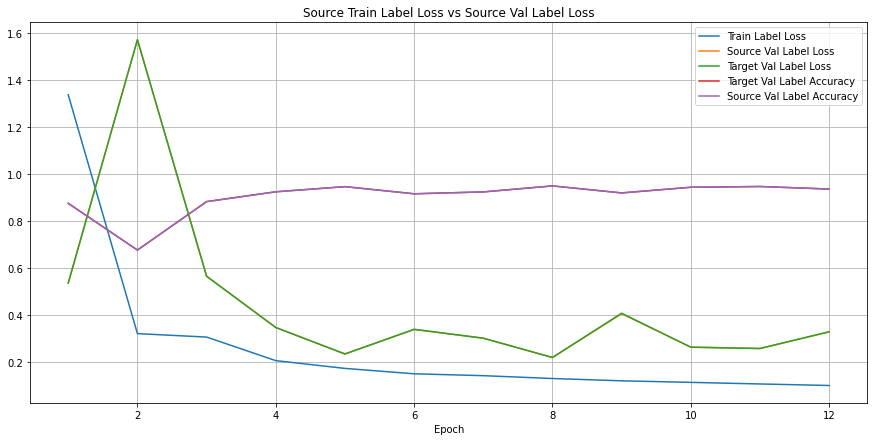

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

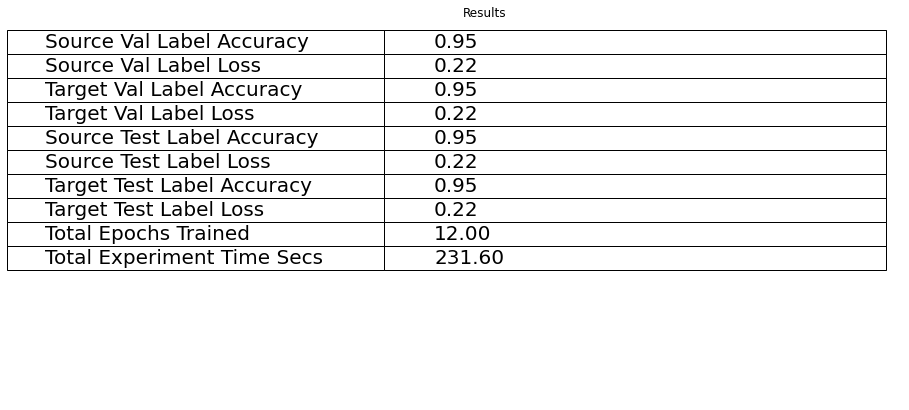

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

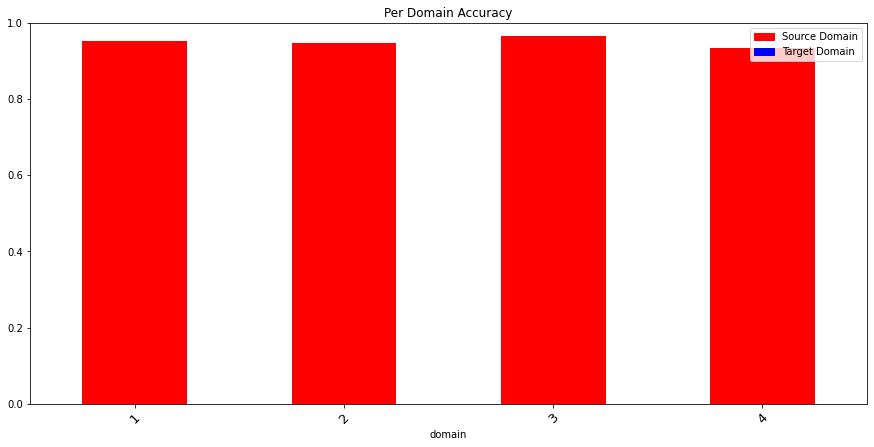

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9493803413600838 Target Test Label Accuracy: 0.9493803413600838
Source Val Label Accuracy: 0.9506888690653187 Target Val Label Accuracy: 0.9506888690653187


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:wisig", "parameters": {"experiment_name": "cnn_2:wisig", "labels": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "3-18", "3-2", "3-8", "4-1", "4-10", "4-11", "5-